<a href="https://colab.research.google.com/github/Erickrus/leetcode/blob/master/GeneticAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 遗传算法 (Genetic Algorithm, GA)

<img src='https://cdn.savemyexams.co.uk/cdn-cgi/image/w=1920,f=auto/uploads/2020/08/Lamarck-theory-of-evolution.png' width=400px/>

## 定义
**遗传算法** 是计算数学中用于解决最优化的搜索算法，是进化算法的一种。进化算法最初是借鉴了进化生物学中的一些现象而发展起来的，这些现象包括遗传、突变、自然选择以及杂交等等。

遗传算法通常实现方式为一种计算机模拟。对于一个最优化问题，一定数量的候选解（称为个体）可抽象表示为染色体，使种群向更好的解进化。

## 算法
本文中的遗传算法，是基于染色体的完全模拟。本文算法实现主要包括：遗传、突变、自然选择。为了简化问题帮助理解，本文未实现杂交

**算法描述**
* 初始化人口
* 循环
  * 评价种群中的个体适应度
  * 选择产生下一个种群
  * 改变该种群（变异）
  * 直到停止循环的条件满足

**GA参数**
* 种群规模（populationSize）：即种群中染色体个体的数目
* 基因长度（geneSize）：个体中染色体的长度
* 突变概率（mutationProb）：控制着突变算子的使用频率
* 中止条件（termination criteria）

**基因表示**

> ACGT 是 DNA 分子中四种碱基的首字母缩写词：腺嘌呤 (A, adenine)、胞嘧啶 (C, cytosine)、鸟嘌呤 (G, guanine) 和胸腺嘧啶 (T, thymine)。 DNA总是以这种方式配对: A-T, T-A, C-G, G-C。

> 本文中的DNA链长40位，每一位表示一个4进制数，这样可以分别表示4个10位的4进制数。


```
GAGCGGTCCG GCCCCAGCCT CGTATGGCCA GGCTGTTTTA 
|||||||||| |||||||||| |||||||||| |||||||||| 
CTCGCCAGGC CGGGGTCGGA GCATACCGGT CCGACAAAAT 

2023221332 2333302331 3210122330 2231211110 
    776930     517118     256283      87674
```

**优化函数** 

> 本文中的优化函数，也就是**自然选择**得分函数，采用的是$negative L2 loss$，$v_i$是基因表达的数值，$t_i$是优化目标，其具体形式如下：

> $score = -\displaystyle\sum^{3}_{i=0}(log_{10}{v_i} - t_i)^2$

> 最大化$score$，就等价于将每个分量$(log_{10}{v_i} - t_i)^2$优化至最小，使的$log_{10}{v_i}$趋近于$t_i$

### 遗传基因模拟

In [ ]:
#@title 遗传基因定义
import gdown
import os
import random
import copy

from PIL import Image, ImageDraw

class Gene:
  def __init__(self):
    self.geneImage = "gene.png"
    # 这里假定DNA链长度为40, 可以表示4个不同的基因
    self.geneSize = 40 #@markdown * 基因长度（geneSize）：个体中染色体的长度
    self.parentId = -1
    self.id = 0
    # 一开始的时候会随机生成一组DNA链
    self.gene = [ self._random_dna_molecule() for i in range(self.geneSize)]
    if not os.path.exists(self.geneImage):
      self._get_gene_png()

  # 下载基因显示图片模版
  def _get_gene_png(self):
    os.system('gdown https://www.genome.gov/sites/default/files/tg/en/illustration/acgt.jpg')
    im = Image.open("acgt.jpg")
    im = im.resize((800,396))
    im = im.crop((0,30,800,336))
    im.save(self.geneImage)
    os.system("rm acgt.jpg")

  # 返回一个随机的DNA配对
  def _random_dna_molecule(self):
    return ['A-T','T-A','C-G','G-C'][random.randint(0,3)]
  
  # 展现一下DNA
  def visualize(self):
    im = Image.open(self.geneImage)
    draw = ImageDraw.Draw(im)
    draw.rectangle([(132,226+5), (670,263+5)], fill=(255,255,255))
    moleculeColors = {'A':(64,183,67),'T':(255,12,18),'G':(0,0,0),'C':(120,169,220)}
    for i in range(len(self.gene)):
      dnaMolecule = self.gene[i]
      draw.text((133 + int(i*13.5), 233), dnaMolecule[0], fill=moleculeColors[dnaMolecule[0]])
      draw.text((133 + int(i*13.5), 253), dnaMolecule[2], fill=moleculeColors[dnaMolecule[2]])
    return im.resize((600,230)) # 精简一下显示尺寸
  
  # 将DNA转化为数值
  def to_array(self):
    dna = [0,0,0,0]
    for i in range(len(self.gene)):
      unit = i // 10
      p = i % 10
      dnaMolecule = self.gene[i][0]
      moleculeValues = {'A':0,'T':1,'G':2,'C':3}
      dna[unit] += moleculeValues[dnaMolecule] * int(4 ** p)
    return dna

  def __str__(self):
    geneText = ["","","","","",""]

    for i in range(len(self.gene)):
      geneText[0] += self.gene[i][0]
      geneText[1] += '|'
      geneText[2] += self.gene[i][2]
      geneText[4] += {'A':'0','T':'1','G':'2','C':'3'}[self.gene[i][0]]
      if i%10 ==9 and i>0:
        geneText[0] += ' '
        geneText[1] += ' '
        geneText[2] += ' '
        geneText[4] += ' '
    values = self.to_array()
    geneText[5] = " ".join(["%10d" for v in values]) % tuple(values)
    geneText = "\n".join(geneText)
    geneText = "id: %d, parentId: %d\n" %(self.id, self.parentId)  + geneText
    return geneText

  # 产生变异
  def mutate(self):
    mutatePosition = random.randint(0, 39)
    self.gene[mutatePosition] = self._random_dna_molecule()
    return mutatePosition
  
  # 繁殖后代
  def born(self, bornId, mutationCount=0):
    g = Gene()
    # 注 这里需要deepcopy 否则数据会错乱
    g.gene = copy.deepcopy(self.gene)
    g.parentId = self.id # 记录父节点id
    g.id = bornId        # 获得下一轮id
    for i in range(mutationCount): # 根据mutationCount进行变异
      g.mutate()
    return g

g = Gene()

id: 0, parentId: -1
GCAAGAAACG AATGCTCAAT GGTCTGACTA TCAAAGCAGA 
|||||||||| |||||||||| |||||||||| |||||||||| 
CGTTCTTTGC TTACGAGTTA CCAGACTGAT AGTTTCGTCT 

2300200032 0012313001 2213120310 1300023020 
    721422     276368     117210     145421


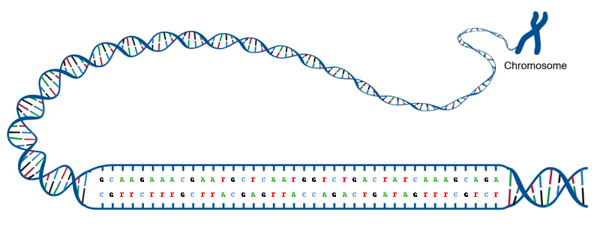

In [ ]:
#@title ###显示基因信息
print(g)
g.visualize()

mutation position: T-A at 13
GATAGCATGG GCATATCCTA ACCGGTGGGA CGGGTACGAT 
|||||||||| |||||||||| |||||||||| |||||||||| 
CTATCGTACC CGTATAGGAT TGGCCACCCT GCCCATGCTA 

2010230122 2301013310 0332212220 3222103201 
    675346     128078     173756     307627


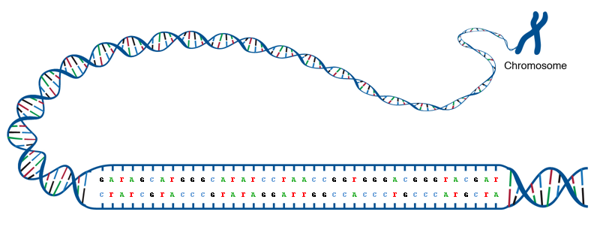

In [ ]:
#@title 基因变异，随机改变其中一个位置
mutationPosition = g.mutate()
print("mutation position: %s at %d" % (g.gene[mutationPosition], mutationPosition))
print(g)
g.visualize()

##自然环境模拟

In [209]:
from typing import Generator
#@title 模拟自然环境定义, 自然选择设定
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import random
import tqdm


%matplotlib inline
from IPython import display



class World:
  def __init__(self, environmentChange=False, convergeAndStop=True):
    self.maxEpochs = 1000         # 总迭代次数
    self.populationSize = 5000    # @markdown * 种群规模（populationSize）：即种群中染色体个体的数目
    self.elitePopulationSize = 10 # 精英人口数
    self.winnerTakesAllNum = 20   # 赢者通吃系数
    self.mutationCount = 1        # @markdown * 突变概率（mutationProb）：控制着突变算子的使用频率
    self.mutationProb = 0.001     # 变异概率
    self.lastEpoch = -1           # 当前迭代数

    self.stats = []               # 各时代的总体统计量
    self.eliteStats = []          # 各时代精英体统计量

    self.populations = self.init_populations() # 人口数
    self.targetNames = ["speed", "size", "weight", "power"] # 优化目标名称
    
    self.environmentChange = environmentChange
    self.convergeAndStop = convergeAndStop

    # 随机优化目标
    self.targets = [random.randint(0,6) for _ in range(4)]
    self._show_optimization_targets()
    

  # 初始化每一代的数据
  def _create_epoch_database(self):
    os.system("rm -Rf epoch_database > /dev/null")
    os.system("mkdir epoch_database")
  
  def save_epoch(self, epoch):
    jsonFilename = os.path.join("epoch_database", (("w%5d.json")%epoch).replace(" ","0"))
    data = {
      "epoch": epoch,
      "populations": [{
        "id":self.populations[i].id, 
        "parentId":self.populations[i].parentId, 
        "gene": self.populations[i].gene
      } for i in range(len(self.populations))],
      "targets": self.targets,
    }
    with open(jsonFilename, "w") as f:
      f.write(json.dumps(data, indent=2, ensure_ascii=False))

  def lineage_analysis(self, startEpoch, id):
    genes = []
    currId = id
    for epoch in reversed(range(startEpoch+1)):
      jsonFilename = os.path.join("epoch_database", (("w%5d.json")%epoch).replace(" ","0"))
      with open(jsonFilename, "r") as f:
        data = json.loads(f.read())
      g = Gene()
      g.id = data["populations"][currId]["id"]
      g.parentId = data["populations"][currId]["parentId"]
      g.gene = data["populations"][currId]["gene"]
      targets = data["targets"]
      genes.append({"epoch": epoch, "gene": g, "targets": targets})
      currId = g.parentId
    for i in range(len(genes)):
      print("epoch: %d" % genes[i]["epoch"])
      print(str(genes[i]["gene"]))
      if i < len(genes)-1:
        if str(genes[i]["targets"]) != str(genes[i+1]["targets"]):
          print("optimization targets: %s" % str(genes[i]["targets"]))
        if genes[i]["gene"].gene != genes[i+1]["gene"].gene:
          print("mutated")
      if i ==len(genes)-1:
        print("optimization targets: %s" % str(genes[i]["targets"]))

      print("\n")
          


  # 根据优化目标进行选择
  def natural_select(self, epoch, animal):
    values = animal.to_array()
    # negative L2 loss
    score = 0.
    for i in range(len(values)):
      score += -(math.log(values[i]+1)/math.log(10) - self.targets[i])**2
    return score

  #@markdown 初始化人口
  def init_populations(self):
    populations = []
    for id in range(self.populationSize):
      # 这里的基因是完全随机的
      animal = Gene()
      animal.id = id
      populations.append(animal)
    return populations

  # 通过随机获得变异次数，不是每次都会变异
  def _get_random_mutation_count(self, prob=0.05):
    mutationCount = 0
    if random.randint(0, int(1./prob)) == 0:
      mutationCount= random.randint(1,self.mutationCount)
    return mutationCount
  
  # 普通群体和精英群体差异小于阈值则表示收敛
  def is_converge(self, threshold=0.01):
    return abs(self.stats[-1] - self.eliteStats[-1]) <= threshold

  def _show_optimization_targets(self):
    fmt = "optimization target "+", ".join(["%s: %s"%(self.targetNames[i], "%d") for i in range(len(self.targetNames))])
    print(fmt % tuple(self.targets))

  def _show_progress(self, epoch):
    plt.plot(np.array(self.stats))
    plt.plot(np.array(self.eliteStats))
    # 普通群体，精英群体
    plt.legend(['General Score', 'Elite Score'])

    # 清屏，重新绘制
    display.clear_output(wait=True)
    print("epoch %d/%d" % (epoch, self.maxEpochs))
    self._show_optimization_targets()

    values = self.populations[0].to_array()
    score = self.natural_select(0, self.populations[0])

    print("%6s: %1.4f" % ("score", score))
    for i in range(len(self.targets)):
       print( "%6s: %1.4f %1.4f"%(self.targetNames[i], math.log(values[i]+1)/math.log(10),  float(self.targets[i])))

    plt.show()


  # 模拟运行，也就是启动物尽天择
  def simulate(self):
    self._create_epoch_database()

    #@markdown 循环
    for epoch in tqdm.tqdm(range(self.maxEpochs)):
      #@markdown > 评价种群中的个体适应度
      scores = [] # 计算当前世代的各生命体的得分情况, 这个得分是基于自然选择的结果
      for id in range(len(self.populations)):
        animal = self.populations[id]
        scores.append({"id": id, "score": self.natural_select(epoch, animal)})
      # 根据自然选择的结果，进行排序，其中分数得分高的排在较上的位置
      # 由于自然选择中的函数选择为 negative L2 loss，所以得分越高，表示越好
      sortedScores = list(reversed(sorted(scores, key=lambda x: x["score"])))

      # 计算统计量
      currScore = np.array([s["score"] for s in sortedScores])       # 根据自然选择得分排序后的得分
      self.stats.append(currScore.mean())                            # 普通群体平均值
      self.eliteStats.append(currScore[:self.elitePopulationSize].mean()) # 精英群体平均值

      #@markdown > 选择产生下一个种群
      # 以下部分，根据得分繁殖下一代
      nextGenerationPopulations = []
      bornId = 0 # 为每个个体分配一个出生id
      for i in range(len(sortedScores)):
        # 对于得分高的精英群体，给予奖励，会产生更多的后代
        # 以下公式含义: 对于排名越靠前的获得奖励越多
        # 前10名 分别可以增加: 20 * 1, 20 * 0.9, 20 * 0.8 ...
        if i <= self.elitePopulationSize-1:
          for j in range(int(self.winnerTakesAllNum * (self.elitePopulationSize-i)/float(self.elitePopulationSize))):
          #@markdown > 改变该种群（变异）
            nextGenerationPopulations.append(
              self.populations[sortedScores[i]["id"]].born(
                bornId = bornId,
                mutationCount=self._get_random_mutation_count(prob=self.mutationProb)
              )
            )
            bornId += 1
        else:
          nextGenerationPopulations.append(
            self.populations[sortedScores[i]["id"]].born(
              bornId = bornId,
              mutationCount=self._get_random_mutation_count(prob=self.mutationProb)
            )
          )
          bornId += 1
        # 那么对于排名靠后的，就被选择淘汰了。此处如果排名靠后就不会产生后代
        # 为了便于计算，此处保持人口总数不变
        if len(nextGenerationPopulations) >= self.populationSize:
          break
      
      self.save_epoch(epoch)
      self.lastEpoch = epoch
      # 下一代了, 上一代 R.I.P
      self.populations = nextGenerationPopulations[:self.populationSize]

      if epoch % 10 == 0 and epoch>0: # 每10代，显示一次当前情况
        self._show_progress(epoch)

      if self.environmentChange and random.randint(0,75) == 0: # 假设环境变了，优化目标发生改变？环境变了？
        self.targets = [random.randint(0,6) for _ in range(4)]
      #@markdown > 直到停止循环的条件满足
      if self.convergeAndStop and self.is_converge(0.1): # 如果提前收敛，则训练结束
        break

    self._show_progress(epoch)


epoch 123/1000
optimization target speed: 3, size: 0, weight: 6, power: 6
 score: -0.0333
 speed: 3.0766 3.0000
  size: 0.0000 0.0000
weight: 5.8501 6.0000
 power: 5.9293 6.0000


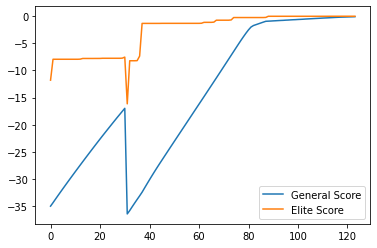

In [210]:
#@title 模拟自然选择的过程
#@markdown 是否允许环境变化:
environmentChange = True #@param {type:"boolean"}
#@markdown 收敛后是否终止执行:
convergeAndStop = True #@param {type:"boolean"}
world = World(environmentChange, convergeAndStop)
world.simulate()

populationId: 3875/4999
score: -0.2728
optimization target ~ speed: 3.0000, size: 0.0000, weight: 6.0000, power: 6.0000
optimization result ~ speed: 3.0777, size: 0.0000, weight: 5.8295, power: 5.5125
id: 3875, parentId: 4819
CGGGATAAAA AAAAAAAAAA GCAAGCATGG GTTTCTCCAT 
|||||||||| |||||||||| |||||||||| |||||||||| 
GCCCTATTTT TTTTTTTTTT CGTTCGTACC CAAAGAGGTA 

3222010000 0000000000 2300230122 2111313301 
      1195          0     675342     325462


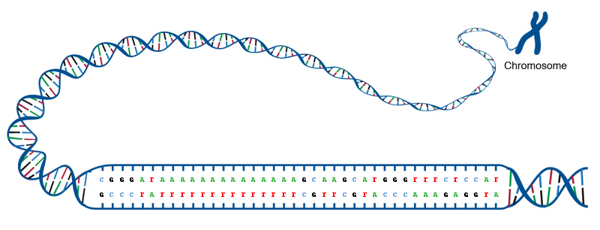

In [211]:
#@title 显示最终的DNA以及对应的参数
#@markdown 根据编号查询 (0-4999):
populationId = 3875 #@param {type:"slider", min:0, max:4999, step:1}
print("populationId: %d/%d" % (populationId, world.populationSize-1))
print("score: %1.4f" % world.natural_select(0, world.populations[populationId]))
fmt = "optimization target ~ "+", ".join(["%s: %s"%(world.targetNames[i], "%1.4f") for i in range(len(world.targetNames))])
print(fmt % tuple(
    world.targets
))
fmt = "optimization result ~ "+", ".join(["%s: %s"%(world.targetNames[i], "%1.4f") for i in range(len(world.targetNames))])
print(fmt % tuple(
    np.log(np.array(world.populations[populationId].to_array())+1.)/np.log(10.)
))
print(world.populations[populationId])
world.populations[populationId].visualize()


In [213]:
#@title 血缘分析
#@markdown 根据编号查询 (0-4999):
populationId = 885 #@param {type:"slider", min:0, max:4999, step:1}
world.lineage_analysis(world.lastEpoch, populationId)

epoch: 123
id: 885, parentId: 550
CGGGATAAAA AAAAAAAAAA GCAAGCATGG GTTTCTCCGC 
|||||||||| |||||||||| |||||||||| |||||||||| 
GCCCTATTTT TTTTTTTTTT CGTTCGTACC CAAAGAGGCG 

3222010000 0000000000 2300230122 2111313323 
      1195          0     675342     980822


epoch: 122
id: 550, parentId: 687
CGGGATAAAA AAAAAAAAAA GCAAGCATGG GTTTCTCCGC 
|||||||||| |||||||||| |||||||||| |||||||||| 
GCCCTATTTT TTTTTTTTTT CGTTCGTACC CAAAGAGGCG 

3222010000 0000000000 2300230122 2111313323 
      1195          0     675342     980822


epoch: 121
id: 687, parentId: 350
CGGGATAAAA AAAAAAAAAA GCAAGCATGG GTTTCTCCGC 
|||||||||| |||||||||| |||||||||| |||||||||| 
GCCCTATTTT TTTTTTTTTT CGTTCGTACC CAAAGAGGCG 

3222010000 0000000000 2300230122 2111313323 
      1195          0     675342     980822


epoch: 120
id: 350, parentId: 487
CGGGATAAAA AAAAAAAAAA GCAAGCATGG GTTTCTCCGC 
|||||||||| |||||||||| |||||||||| |||||||||| 
GCCCTATTTT TTTTTTTTTT CGTTCGTACC CAAAGAGGCG 

3222010000 0000000000 2300230122 2111313323 
  